# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ITMO][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [220]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [221]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций.

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [222]:
def _format_features_sign(y: np.ndarray) -> np.ndarray:
    classes = np.unique(y)
    y_copy = y.copy()
    y_copy[y_copy == classes[0]] = -1
    y_copy[y_copy == classes[1]] = 1
    return y_copy.reshape(-1, 1)

def _format_X(X: np.ndarray) -> np.ndarray:
    return np.hstack(tup = (np.ones(X.shape[0]).reshape(-1, 1), X))

In [223]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения),
        w[0] должен соответстовать константе,
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.

        """
        self.w = None
        self.iterations = iterations
        self.classes = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон.
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.

        """
        self.classes = np.unique(y)
        X = _format_X(X)
        y = _format_features_sign(y)
        self.w = np.zeros(shape = (X.shape[1], 1))

        for i in range(self.iterations):
            v_sign = np.sign(X @ self.w)
            v_not_eq_feat = v_sign != y
            mask = v_not_eq_feat.T[0]
            self.w += np.sum((X * y)[mask], axis=0).reshape(-1, 1)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.

        Return
        ------
        labels : np.ndarray
            Вектор индексов классов
            (по одной метке для каждого элемента из X).

        """
        X = _format_X(X)
        y = np.sign(X @ self.w).T[0]
        return np.asarray(list(map(lambda x: self.classes[0] if x == -1 else self.classes[1], y)))

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

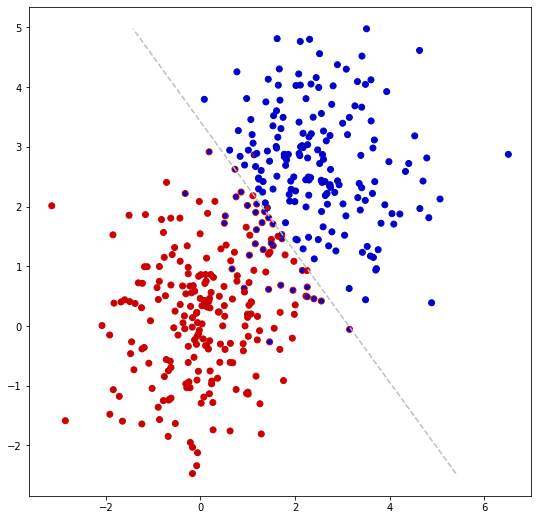

In [224]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

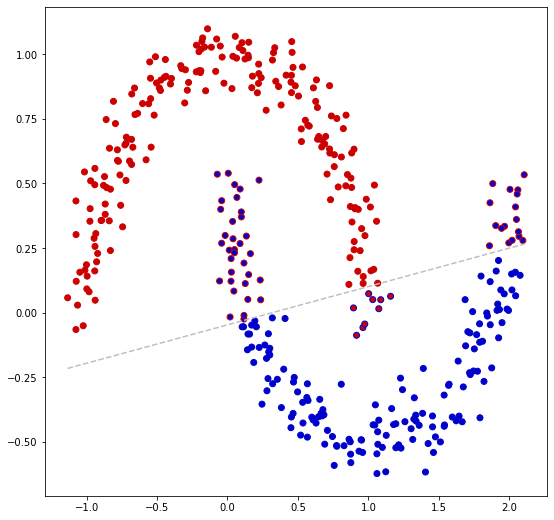

In [225]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса.

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [226]:
class PerceptronBest:

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения),
        w[0] должен соответстовать константе,
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.

        """
        self.w = None
        self.iterations = iterations
        self.classes = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса,
        при которых значение accuracy было наибольшим.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.

        """
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
        X = X_train
        y = y_train

        self.classes = np.unique(y)
        X = _format_X(X)
        y = _format_features_sign(y).reshape(-1, 1)
        self.w = np.zeros(shape = (X.shape[1], 1))
        accuracy_max = 0.0
        best_w = self.w.copy()

        for i in range(self.iterations):
            v_sign = np.sign(X @ self.w)
            v_not_eq_feat = v_sign != y
            mask = v_not_eq_feat.T[0]
            self.w += np.sum((X * y)[mask], axis=0).reshape(-1, 1)
            if i != 0:
                accuracy_curr = np.mean(self.predict(X_test) == y_test)
                if accuracy_curr > accuracy_max:
                    accuracy_max = accuracy_curr
                    best_w = self.w.copy()
            if i == self.iterations - 1:
                self.w = best_w

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.

        Return
        ------
        labels : np.ndarray
            Вектор индексов классов
            (по одной метке для каждого элемента из X).

        """
        X = _format_X(X)
        y = np.sign(X @ self.w).T[0]
        return np.asarray(list(map(lambda x: self.classes[0] if x == -1 else self.classes[1], y)))


Посмотрим на то, как наш перцептрон справляется с различными наборами данных

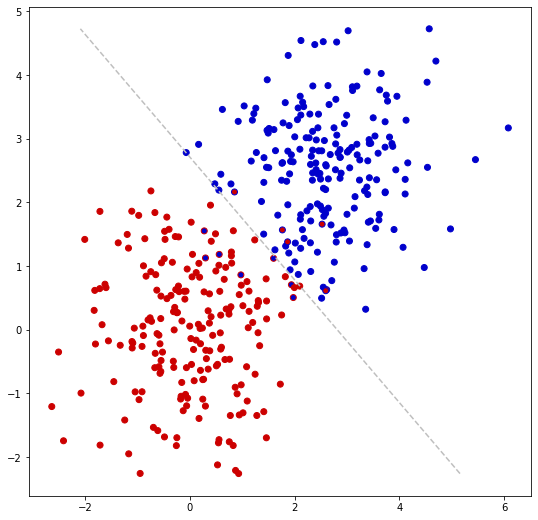

In [227]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

/Users/thebest/Documents/HSE/semester_5/ЧМ/hw2/venv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


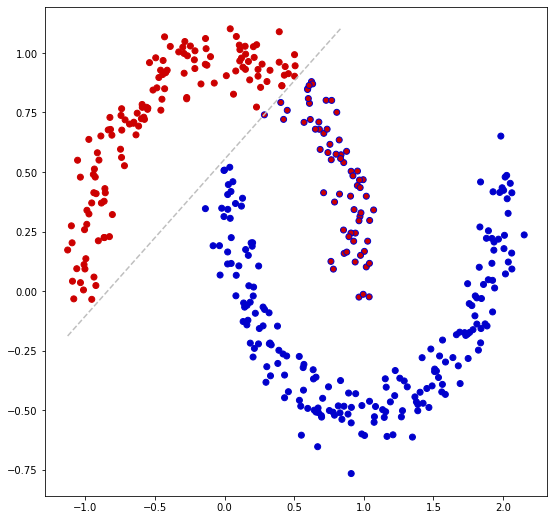

In [228]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [229]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
    Первая компонента - среднее значение вертикальной матрицы симметричности
    Вторая компонента - количество точек > EPS, достаточно плотных

    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    result = np.zeros((images.shape[0], 2))
    result[:, 0] = np.abs(images - images[:, ::-1, :]).mean(axis=(1, 2))
    result[:, 0] /= max(result[:, 0])

    EPS = 0.3
    for i, image in enumerate(images):
        cnt = sum(list(map(lambda line:
                           len(list(filter(lambda val:
                                           val > EPS, line))),
                 image)))
        result[i, 1] = cnt
    result[:, 1] /= max(result[:, 1])

    return result

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков.

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [230]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

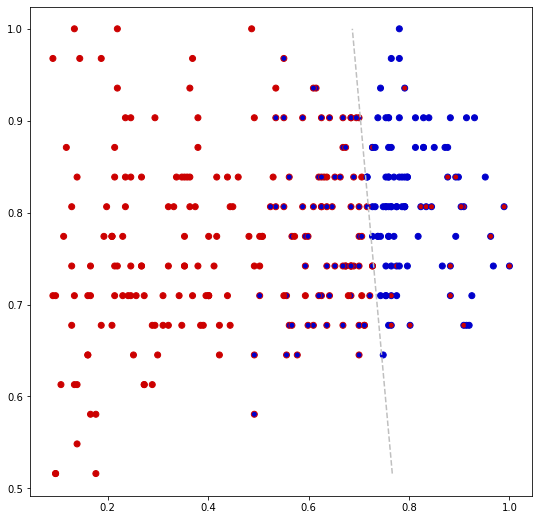

Accuracy: 0.684931506849315


In [231]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

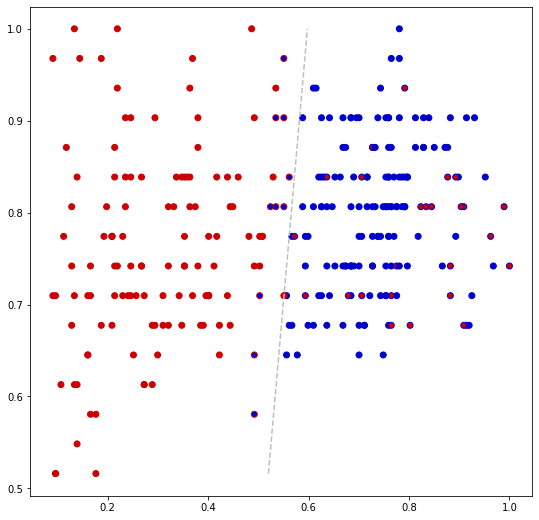

Accuracy: 0.9041095890410958


In [232]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [233]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6338767170926796


In [234]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7005783985155648
